### Pitman-Yor Multinomial processes

### Import

In [105]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from methods import *
from rlaptrans import *
from nonparametricMLE import *
import pandas as pd
from statsmodels.discrete.discrete_model import Probit

### Parameters

In [51]:
alpha = 2.0
sigma = .7
H = 100
K = 500 # Plotting resolution
T = 300_000 # Upper bound on number of iterations
m = 20 # Number of realisations to plot
requiredESS = 2_000 

### Data

In [15]:
df = pd.read_csv('rubella.csv')
df.head()

,age,successes,trials
0,0.2740,0,1
1,0.3781,0,1
2,0.5288,0,1
3,0.5342,0,1
4,0.9452,1,1


In [16]:
logages = np.log(np.array(df['age'].tolist()))
successes = np.array(df['successes'].tolist())
n = len(logages)

#### Rescalce

In [17]:
probitalpha, probitbeta = Probit(successes, np.column_stack((np.ones((len(logages), 1)), logages))).fit(disp=False).params
logages = logages*probitbeta + probitalpha

In [18]:
obsleft = logages[successes == 1]
obsright = logages[successes == 0]

nleft = len(obsleft)
nright = len(obsright)

### Methods

In [23]:
@nb.njit(nb.float64[:](nb.float64[:], nb.float64[:], nb.int64))
def numba_choice_sampler(array, probabilities, size):
    cumsump = np.cumsum(probabilities)
    result = np.zeros(size)
    for i in range(size):
        u = np.random.random()
        index = np.argmax(u <= cumsump)
        result[i] = array[index]
    return result


@nb.njit(nb.float64[:,:](nb.float64[:,:],
                         nb.float64[:,:],
                         nb.float64[:],
                         nb.int64,
                         nb.int64))
def get_posterior_cdfs(sortedpis, sortedthetas, space, T, K):
    posterior_cdfs = np.zeros((T, K))
    for t in range(T):
        for k in range(K):
            posterior_cdfs[t][k] = np.sum(sortedpis[t][sortedthetas[t] <= space[k]])
    return posterior_cdfs
        

In [24]:
@nb.njit(nb.types.Tuple((nb.float64[:,:], nb.float64[:,:], nb.float64[:,:], nb.float64[:], nb.int64))(nb.float64,
                                                                                                      nb.float64,
                                                                                                      nb.int64,
                                                                                                      nb.int64,
                                                                                                      nb.int64,
                                                                                                      nb.int64,
                                                                                                      nb.float64[:],
                                                                                                      nb.float64[:]))
def main_simulation(alpha, sigma, H, T, requiredESS, n, obsleft, obsright):
    data = np.zeros((T, n))
    thetas = np.zeros((T, H))
    pis = np.zeros((T, H))
    logpermanents = -np.inf*np.ones(T)
    
    nleft = len(obsleft)
    nright = len(obsright)
    boundaries = np.sort(np.array([-np.inf, np.inf] + list(obsleft) + list(obsright)))
    
    logreqESS = np.log(requiredESS)
    logESS = -np.inf
    
    t = 0
    num_zero_permanents = 0
    
    while logESS < logreqESS:
        U = np.random.gamma(shape=alpha/sigma, scale=1/1)**(1/sigma)
        J = rlaptrans(H, sigma, H, U, tol=1e-7, x0=1.0, xinc=2.0, m=11, L=1, A=19, nburn=38)
        pi = J/np.sum(J)
        theta = np.random.randn(H)
        x = numba_choice_sampler(theta, pi, n)
        x = np.sort(x)
        
        # Continue if permanent is zero
        nonzero_permanent = True
        for i in range(nleft):
            if x[i] > obsleft[i]:
                nonzero_permanent = False
                break
        for i in range(nright):
            if x[nleft + i] <= obsright[i]:
                nonzero_permanent = False
                break
        if not nonzero_permanent:
            num_zero_permanents += 1
            continue
        
        # Calculate permanent
        a, b, c = get_abc(x, obsleft, obsright, boundaries)
        logP = logpermanent_calculator(a, b, c, n)
        
        data[t] = x
        thetas[t] = theta
        pis[t] = pi
        logpermanents[t] = logP
        
        logESS = 2*logsumexp_array(logpermanents) - logsumexp_array(2*logpermanents)
        t += 1
    return data, thetas, pis, logpermanents, num_zero_permanents

### Simulations

In [25]:
%%time 
data, thetas, pis, logPs, num_zero_permanents = main_simulation(alpha, sigma, H, T, requiredESS, n, obsleft, obsright)

CPU times: total: 1min 11s
Wall time: 53.7 s


In [55]:
data = data[logPs > -np.inf]
thetas = thetas[logPs > -np.inf]
pis = pis[logPs > -np.inf]
logPs = logPs[logPs > -np.inf]
T = len(logPs)

### Simulation efficiency

In [34]:
print(f'Number of nonzero permanents: {T}')
print(f'Number of zero permanents: {num_zero_permanents}')

Number of nonzero permanents: 1006
Number of zero permanents: 789


## Remove before uploading to github

In [ ]:
np.save('data.npy', data)
np.save('thetas.npy', thetas)
np.save('pis.npy', pis)
np.save('logPs.npy', logPs)

### Load data

In [ ]:
data = np.load('data.npy')
thetas = np.load('thetas.npy')
pis = np.load('pis.npy')
logPs = np.load('logPs.npy')

### Plot

#### Sort

In [35]:
argsorted = np.argsort(thetas, axis=1)
sortedpis = np.zeros((T, H))

for t in range(T):
    sortedpis[t] = pis[t][argsorted[t]]
    
sortedthetas = np.sort(thetas, axis=1)

#### Posterior cdfs

In [36]:
space = np.linspace(np.min(thetas), np.max(thetas), K)

In [38]:
%%time
posterior_cdfs = get_posterior_cdfs(sortedpis, sortedthetas, space, T, K)

CPU times: total: 234 ms
Wall time: 228 ms


##### Posterior mean

In [39]:
logfactorial = 0
for i in range(1, n+1):
    logfactorial += np.log(i)

In [40]:
posterior_mean_cdf = np.mean(np.exp(logPs - logfactorial).reshape((T, 1))*posterior_cdfs, axis=0)
posterior_mean_cdf /= posterior_mean_cdf[-1]

In [53]:
len(logPs)

1006

In [54]:
T

300000

##### Individual realisations

In [57]:
realisations = np.zeros((M, K))
probs = np.exp(logPs - logfactorial)
probs /= np.sum(probs)

for j in range(m):
    index = np.random.choice(T, p=probs)
    realisations[j] = posterior_cdfs[index]

#### Nonparametric MLE

In [89]:
tMLE, dMLE = get_nonparametric_mle(logages, successes)

In [90]:
restricted_space = space[(space >= min(tMLE)) * (space <= max(tMLE))]
restricted_posterior_mean_cdf = posterior_mean_cdf[(space >= min(tMLE)) * (space <= max(tMLE))]
restricted_prior_mean_cdf = np.mean(posterior_cdfs, axis=0)[(space >= min(tMLE)) * (space <= max(tMLE))]

In [99]:
restricted_realisations = np.zeros((m, len(restricted_space)))

In [100]:
for j in range(m):
    restricted_realisations[j] = realisations[j][(space >= min(tMLE)) * (space <= max(tMLE))]

In [92]:
origspace = np.exp((restricted_space - probitalpha)/probitbeta)

#### Plot a

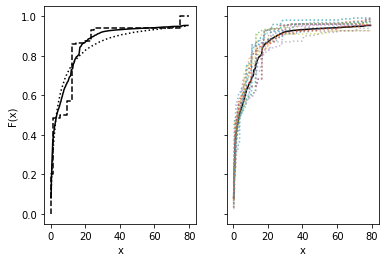

In [104]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

axs[0].plot(origspace, restricted_posterior_mean_cdf, color='black')
axs[0].plot(origspace, restricted_prior_mean_cdf, color='black', linestyle='dotted')
axs[0].step(np.exp((tMLE - probitalpha)/probitbeta), dMLE, color='black', linestyle='dashed')

axs[1].plot(origspace, restricted_posterior_mean_cdf, color='black')
axs[1].plot(origspace, restricted_realisations.T, alpha=.5, linestyle='dotted')

axs[0].set_ylabel('F(x)')
axs[0].set_xlabel('x')
axs[1].set_xlabel('x')
plt.savefig('PYMfigure.pdf', format='pdf')